# Reinforcement Learning with Atari Games

This notebook acts as a demo application for researchers and developers that want to run DQN and PPO algorithms with (or without) Curiosity and Empowerment Intrinsic Motivation (IM).

[User flowchart](../imgs/user-flowchart.png)

It focuses on a six stage process outlined below:
1. [Hyperparameter setup](#1.-Hyperparameter-Setup)
2. [Creating a model](#2.-Model-Creation)
3. [Training a model](#3.-Model-Training)
4. [Loading a model](#4.-Load-Model)
5. [Validating models](#5.-Model-Validation)
6. [Improving models](#6.-Improving-Models)

## 1. Hyperparameter Setup

Hyperparameters are defined in a YAML file stored in the root directory. The default file name is `parameters.yaml`, however, custom filenames are suppliable into the `custom_models()` function (refer to section 2). The hyperparameters must follow the template format as defined in the `core/template.yaml` file. 

Please note: not all parameters are required, they depend on the type of model and IM methods you are using.

Below shows an example of accessing `utility parameters` (ones not defined in the core template).

In [1]:
from core.create import get_utility_params

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# Get utility parameters from yaml file
util_params = get_utility_params()
print(util_params)

# Set them as hyperparameters
NUM_EPISODES = util_params['num_episodes']
SAVE_EVERY = util_params['save_every']
print(f'NUM_EPISODES={NUM_EPISODES}, SAVE_EVERY={SAVE_EVERY}')

env2 = util_params['env_2']
env3 = util_params['env_3']
print(f'env2={env2}, env3={env3}')

{'env_3': 'ALE/MontezumaRevenge-v5', 'num_episodes': 100000, 'save_every': 10000, 'env_2': 'ALE/Qbert-v5'}
NUM_EPISODES=100000, SAVE_EVERY=10000
env2=ALE/Qbert-v5, env3=ALE/MontezumaRevenge-v5


## 2. Model Creation

Firstly, we set the device that the model is loaded onto. This can be either a GPU (`cuda:[id]`) or CPU (`cpu`). By default, it will automatically select the best device for your system. If multiple GPU's are available, it will only select one of the GPU's that are over a provided threshold (default is 2GB). For more information on the `set_device()` function, see below:

_Function_: `set_device(device: str = None, threshold: float = 2e9)` <br>
_Parameters_:<br>
    &nbsp;&nbsp;1. `device` - an (optional) string value that defines a predetermined CUDA device to use. E.g., `cpu` or `cuda:0` for first GPU device.<br>
    &nbsp;&nbsp;2. `threshold` - an (optional) float value that acts as an acceptance threshold for GPU devices. When provided, a GPU will only be loaded with enough space specified by this threshold.<br>
_Returns_: a string of the CUDA device.

In [3]:
from utils.helper import set_device

device = set_device()

CUDA available. Device set to GPU -> 'cuda:0'.


Next, we create the model itself using the `create_model()` function from the `core.create` package. 

_Function_: `create_model(model_type: str, env: str = 'primary', device: str = None, filename: str = 'parameters', im_type: str = None)`<br>
_Parameters_:<br>
    &nbsp;&nbsp;1. `model_type` - a string value containing the name of the model to create. Options: `['dqn', 'ppo', 'rainbow']`<br>
    &nbsp;&nbsp;2. `env` - a string value denoting the Gym environment name. Defaults to `primary` which dynamically retrieves the `env_name` from the `parameters.yaml` file.<br>
    &nbsp;&nbsp;3. `device` - a string value representing the CUDA device to load the model onto.<br>
    &nbsp;&nbsp;4. `filename` - an (optional) string value for the YAML file that contains the hyperparmeters. Defaults to `parameters`.<br>
    &nbsp;&nbsp;5. `im_type` - a string value for the type of intrinisic motivation to use. Options: `[None, 'curiosity', 'empowerment']`. Defaults to `None`.<br>
_Returns_: a model of the specified `model_type`.

In [4]:
from core.create import create_model

dqn = create_model('dqn', env='primary', device=device)
ppo = create_model('ppo', env=env3, device=device, im_type='curiosity')

For debugging purposes, certain attributes are accessible.

All models: `[env_details, params, device, seed, logger, im_type, im_method, optimizer, loss]`<br>
DQN: `[env, action_size, memory, local_network, target_network]`<br>
PPO: `[envs, buffer, network, num_envs, batch_size, mini_batch_size]`<br>
Rainbow: `[env, action_size, batch_size, buffer_params, buffer, local_network, target_network, z_delta, z_support, discount_scaling, priority_weight, priority_weight_increase]`

Note: `env_details` and `params` are individual classes containing additional parameters. `env_details` stores the `environment` parameters from the `parameters.yaml` file, and `params` the parameters unique to model. All parameters are stored in data classes and act as such when accessed. 

Note: `env_details` is printed as a dictionary but all key values are accessible via variables.

In [5]:
print(dqn.params)
print(ppo.params)

DQNParameters(gamma=0.99, tau=0.001, update_steps=4, max_timesteps=1000, target_update_steps=1000, buffer_size=1000, batch_size=32, eps_start=1.0, eps_end=0.1, eps_decay=0.995)
PPOParameters(gamma=0.99, update_steps=4, loss_clip=0.1, rollout_size=10, num_envs=4, num_mini_batches=4, entropy_coef=0.01, value_loss_coef=0.5, clip_grad=0.5)


In [6]:
print(dqn.logger)
print(dqn.logger.actions)

Available attributes: '['actions', 'train_losses', 'ep_scores', 'intrinsic_losses']'
[]


In [7]:
print(ppo.env_details)
print(ppo.env_details.gym_name)

{'gym_name': 'ALE/MontezumaRevenge-v5', 'name': 'MontezumaRevenge', 'obs_space': Box(0, 255, (4, 84, 84), uint8), 'action_space': Discrete(18), 'input_shape': (4, 84, 84), 'n_actions': 18, 'img_size': 84, 'stack_size': 4, 'capture_video': False, 'record_every': 10000}
ALE/MontezumaRevenge-v5


## 3. Model Training

We train a model using its respective `train()` function. Each model has the same parameters supplied but performs different functionality.

_Function_: `model.train(num_episodes: int, print_every: int = 100, save_count: int = 1000)`<br>
_Parameters_:<br>
    &nbsp;&nbsp;1. `num_episodes` - an integer value denoting the maximum number of episodes to train for.<br>
    &nbsp;&nbsp;2. `print_every` - an integer value representing the episode number to provide progress updates. Note: the first and last episodes are always inclusive.<br>
    &nbsp;&nbsp;3. `save_count` - an integer value representing the episode number to save the models state.<br>
_Returns_: a trained model.

In [8]:
dqn.train(num_episodes=5, print_every=1, save_count=5)

Training agent on SpaceInvaders with 5 episodes.
Buffer size: 1k, batch size: 32, max timesteps: 1k, num network updates: 4, intrinsic method: None
(1.0/5) Episode Score: 120,  Train Loss: 152430.37500,  Time taken: 5 secs.
(2.0/5) Episode Score: 65,  Train Loss: 2602.01025,  Time taken: 3 secs.
(3.0/5) Episode Score: 380,  Train Loss: 107.50909,  Time taken: 5 secs.
(4.0/5) Episode Score: 110,  Train Loss: 42.46745,  Time taken: 3 secs.
(5.0/5) Episode Score: 135,  Train Loss: 82.25395,  Time taken: 2 secs.
Saved model at episode 5 as: 'dqn_batch32_buffer1k_SpaInv_ep5.pt'.
Saved logger data to 'saved_models/dqn_SpaInv_logger_data.tar.gz'. Total size: 806 bytes
Training complete. Access metrics from 'logger' attribute. 

In [9]:
ppo.train(num_episodes=5, print_every=1, save_count=10)

Training agent on MontezumaRevenge with 200 episodes.
Surrogate clipping size: 0.1, rollout size: 10, num environments: 4, num network updates: 4, batch size: 40, training iterations: 5, intrinsic method: curiosity.
(1.0/5) Episode Score: 0.00,  Episodic Return: 0.05,  Approx KL: -0.002,  Total Loss: 5506.267,  Policy Loss: -0.000,  Value Loss: 5272.521,  Entropy Loss: 2.888,  Curiosity Loss: 5222.00977,  Time taken: 0 secs.
(2.0/5) Episode Score: 0.00,  Episodic Return: 0.34,  Approx KL: 0.023,  Total Loss: 5508.791,  Policy Loss: -0.016,  Value Loss: 5273.366,  Entropy Loss: 2.879,  Curiosity Loss: 5240.09814,  Time taken: 0 secs.
(3.0/5) Episode Score: 0.00,  Episodic Return: 1.40,  Approx KL: 0.002,  Total Loss: 5459.398,  Policy Loss: -0.090,  Value Loss: 5176.632,  Entropy Loss: 2.723,  Curiosity Loss: 5188.22217,  Time taken: 1 secs.
(4.0/5) Episode Score: 0.00,  Episodic Return: 4.78,  Approx KL: 0.629,  Total Loss: 5521.161,  Policy Loss: -0.345,  Value Loss: 5265.684,  Entrop

Trained model information is accessible via its `logger` attribute as shown below.

In [10]:
print(dqn.logger)
print(ppo.logger)

Available attributes: '['actions', 'train_losses', 'ep_scores', 'intrinsic_losses']'
Available attributes: '['actions', 'avg_returns', 'avg_rewards', 'policy_losses', 'value_losses', 'entropy_losses', 'total_losses', 'approx_kl', 'intrinsic_losses']'


In [11]:
print(dqn.logger.actions)
print(ppo.logger.actions)

[Counter({3: 477, 0: 456, 1: 453, 2: 441, 4: 431, 5: 414})]
[Counter({6: 208, 16: 68, 4: 64, 1: 60, 9: 56, 17: 48, 15: 44, 8: 36, 5: 32, 3: 28, 2: 28, 14: 24, 0: 24, 11: 20, 10: 20, 12: 16, 13: 12, 7: 12})]


## 4. Load Model

Previously trained models are loaded using the `load_model()` function from the `utils.model_utils` package.

_Function_: `load_model(filename: str, device: str)`<br>
_Parameters_:<br>
    &nbsp;&nbsp;1. `filename` - a filename of the model to load. This file must be stored in a `saved_models` directory and contain the type of model and its IM type at the start of the filename.<br>
    &nbsp;&nbsp;&nbsp;&nbsp;For example, `dqn_batch32_buffer1k_SpaInv_ep5` for a DQN model without IM, `ppo-cur_SpaInv_ep5` for a PPO model with Curiosity, and `rainbow-emp_SpaInv_ep5` for a Rainbow model with Empowerment.<br>
    &nbsp;&nbsp;&nbsp;&nbsp;Prefixes must be one of: `[dqn, dqn-cur, dqn-emp, ppo, ppo-cur, ppo-emp, rainbow, rainbow-cur, rainbow-emp]`.<br>
    &nbsp;&nbsp;2. `device` - a string value representing the CUDA device to load the model onto.<br>
_Returns_: the loaded model with all its parameters.

Note: a logger data file is required to load a models metric information. The filename for the logger must prefix in a similar way to the `filename` parameter. For example, `dqn_SpaInv_logger_data.tar.gz`.

In [12]:
from utils.model_utils import load_model

model = load_model('dqn_batch32_buffer1k_SpaInv_ep5', device=device)

Loaded model: 'dqn_batch32_buffer1k_SpaInv_ep5.pt'


In [13]:
model.logger

Available attributes: '['actions', 'train_losses', 'ep_scores', 'intrinsic_losses']'

In [14]:
model.logger.actions

[Counter({4: 431, 1: 453, 0: 456, 2: 441, 5: 414, 3: 477})]

## 5. Model Validation

Models can be validated using several options, depending on your requirements. To watch the agent in its environment we use `video_render()`, to simply check its episode score `test_model()`, or visualise its results we use `plot_data()`. `test_model()` and `plot_data()` are accessible from the `utils.validate` package, `video_render()` from `utils.render`.

_Function_: `video_render(agent: Agent, episodes: int = 5)` or `test_model(agent: Agent, episodes: int = 100)`<br>
_Parameters_:<br>
    &nbsp;&nbsp;1. `agent` - a recently trained or loaded agent.<br>
    &nbsp;&nbsp;2. `episodes` - an integer representing the number of episodes to watch/perform in its environment.<br>
_Returns_: a video of the agent performing in the environment, or a list of episode scores.

In [15]:
from utils.render import video_render

video_render(model, 1)

(1/1) Score: 135


In [16]:
from utils.validate import test_model

scores = test_model(model, 10)
print(scores)

(1/10) Episode score: 380
(10/10) Episode score: 560
Scores avg: 370.0
[380.0, 460.0, 165.0, 245.0, 245.0, 255.0, 540.0, 685.0, 165.0, 560.0]


_Function_: `plot_data(data: tuple[list, list], plot_type: str, format_dict: dict, figsize: tuple = (8, 6), graph_params: dict = None, filename: str = None)`<br>
_Parameters_:<br>
    &nbsp;&nbsp;1. `data` - up to two lists of data, represented as a tuple, containing the information to display on the x and y axes. The number of lists will vary depending on the type of plot selected. `['line', 'scatter', 'bar']` require two lists `(x, y)`, while `['histogram', 'boxplot']` only requires one `(x,)`.<br>
    &nbsp;&nbsp;2. `plot_type` - a string containing the type of plot to use. Options: `['line', 'scatter', 'bar', 'histogram', 'boxplot']`.<br>
    &nbsp;&nbsp;3. `format_dict` - a dictionary containing plot formatting information. Required keys: `['title', 'xlabel', 'ylabel']`. Optional keys: `['disable_y_ticks', 'disable_x_ticks']`.<br>
    &nbsp;&nbsp;4. `figsize` - an (optional) tuple containing integer values for the `(column, row)` size of the plot figure.<br>
    &nbsp;&nbsp;5. `graph_params` - an (optional) dictionary of parameters containing additional parameters unique to the selected graph. Refer to the matplotlib documentation for more details.<br>
    &nbsp;&nbsp;6. `filename` - an (optional) string containing a filepath and name of the plot to save it onto your machine. E.g., `/plots/ppo-cur_SpaInv.png`.<br>
_Returns_: a plot of the data.

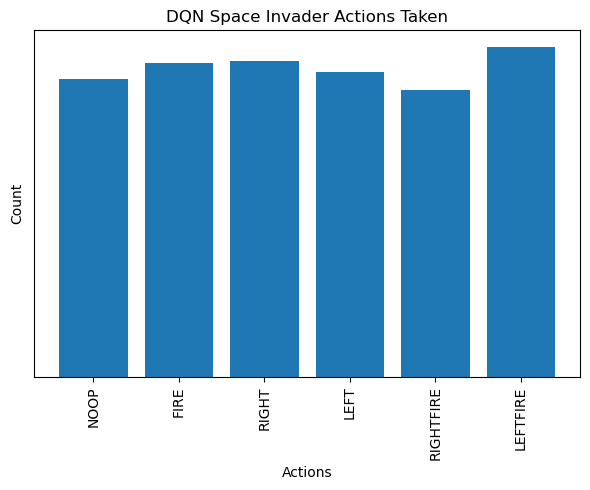

In [17]:
from utils.validate import plot_data

x = list(model.logger.actions[0].values())
action_names_func = lambda m: m.env_details.make_env(m.env_details.gym_name).env.get_action_meanings()
action_names = action_names_func(model)

plot_data((action_names, x), plot_type='bar', format_dict={'title': 'DQN Space Invader Actions Taken', 'xlabel': 'Actions', 'ylabel': 'Count', 'disable_y_ticks': True}, figsize=(6, 5))

## 6. Improving Models

To improve a model, we use the `improve_model()` function from the `utils.model_utils` package. 

_Function_: `improve_model(load_model_params: dict, train_params: dict, ep_total: int)`<br>
_Parameters_:<br>
    &nbsp;&nbsp;1. `load_model_params` - a dictionary containing the `load_model()` function parameters. Requires: `{'filename': '', 'device': ''}`.<br>
    &nbsp;&nbsp;2. `train_params` - a dictionary containing the `model.train()` function parameters. Requires: `{'print_every': 0, 'save_count': 0}`.<br>
    &nbsp;&nbsp;3. `ep_total` - an integer value representing the number of episodes to reach during training. E.g., `int(1e5)`.<br>
_Returns_: an improved version of the supplied model.

In [18]:
from utils.model_utils import improve_model

device = 'cuda:0'
filename = 'dqn_batch32_buffer1k_SpaInv_ep5'
load_model_params = {'filename': filename, 'device': device}
train_params = {'print_every': 1, 'save_count': 100}

improved_model = improve_model(load_model_params, train_params, ep_total=10)

Loaded model: 'dqn_batch32_buffer1k_SpaInv_ep5.pt'
Starting training from 5.0 episodes for a further 5.0 (10.0 total).
Training agent on SpaceInvaders with 5 episodes.
Buffer size: 1k, batch size: 32, max timesteps: 1k, num network updates: 4, intrinsic method: None
(6.0/10) Episode Score: 120,  Train Loss: 110.59046,  Time taken: 2 secs.
(7.0/10) Episode Score: 65,  Train Loss: 97.15627,  Time taken: 2 secs.
(8.0/10) Episode Score: 80,  Train Loss: 135.17920,  Time taken: 1 secs.
(9.0/10) Episode Score: 155,  Train Loss: 72.77246,  Time taken: 3 secs.
(10.0/10) Episode Score: 155,  Train Loss: 120.21696,  Time taken: 2 secs.
Training complete. Access metrics from 'logger' attribute. 

In [19]:
print(improved_model.logger)
print(improved_model.logger.actions)

Available attributes: '['actions', 'train_losses', 'ep_scores', 'intrinsic_losses']'
[Counter({3: 907, 0: 853, 1: 852, 2: 814, 5: 807, 4: 806})]
